In [49]:
# Import libraries
import pandas as pd
import numpy as np

Final data cleaning will be done using Spreadsheets - faster and easier to visualize. 
The steps taken were: 

* Normalizing the spelling of each neighborhood to match with the nyc_df.csv file
* Changing neighborhood of locations that don't have the correct neighborhood

In [50]:
# Use merge df that has no duplicates
df = pd.read_csv('/home/eduardo/nyc-neighborhoods/data//nyc_health_borough.csv', )
df.drop('Unnamed: 0', axis=1, inplace=True)
df

,Venue,Category,Latitude_x,Longitude_x,Neighborhood,ZIP,Borough,Longitude_y,Latitude_y
0,Wakefield Eye Care,Optometrist,40.898682,-73.849352,Wakefield,10466,Bronx,-73.847201,40.894705
1,Advanced Dental Group,Dentist,40.875278,-73.828492,Co-op City,10475,Bronx,-73.829939,40.874294
2,Creating Smiles,Dentist,40.871558,-73.830285,Co-op City,10475,Bronx,-73.829939,40.874294
3,NYC Health & Hospitals,Medical Center,40.873701,-73.826771,Co-op City,10475,Bronx,-73.829939,40.874294
4,Montefiore Medical Group,Physician,40.877116,-73.828470,Co-op City,10475,Bronx,-73.829939,40.874294
...,...,...,...,...,...,...,...,...,...
5859,Staten Island Dental Arts Center,Dentist,40.529627,-74.202826,Prince's Bay,10309,Staten Island,-74.201526,40.526264
5860,Arverne Dental,Dentist,40.587008,-73.811274,Hammels,11693,Queens,-73.805530,40.587338
5861,Beach Ny Physical Ther,Physical Therapy Clinic,40.587227,-73.811108,Hammels,11693,Queens,-73.805530,40.587338
5862,Heritage Adult Care,Healthcare Clinic,40.587227,-73.811108,Hammels,11693,Queens,-73.805530,40.587338


In [58]:
# How many neighborhoods are there? 
df['Neighborhood'].nunique()

227

In [75]:
df_2d = df.groupby('Neighborhood').count().drop([
    'Category', 'Latitude_x', 'Longitude_x', 'ZIP', 'Borough', 'Longitude_y', 'Latitude_y'], axis=1)

In [111]:
df_2d.head(5)

,Venue
Neighborhood,
Allerton,17
Annadale,4
Arden Heights,4
Arlington,1
Arrochar,7


In [70]:
# import Kmeans 
from sklearn.cluster import KMeans
# import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

In [91]:
# Instantiate the scaler
scaler = MinMaxScaler()
 
# Create a scaled data frame
scaled_data = scaler.fit_transform(df_2d.to_numpy())
df_scaled = pd.DataFrame(scaled_data)
df_scaled.columns = ['Venue count']

In [92]:
df_scaled.head(3)

,Venue count
0,0.092486
1,0.017341
2,0.017341


In [79]:
def plot_distortion(df_scaled,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(df_scaled)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

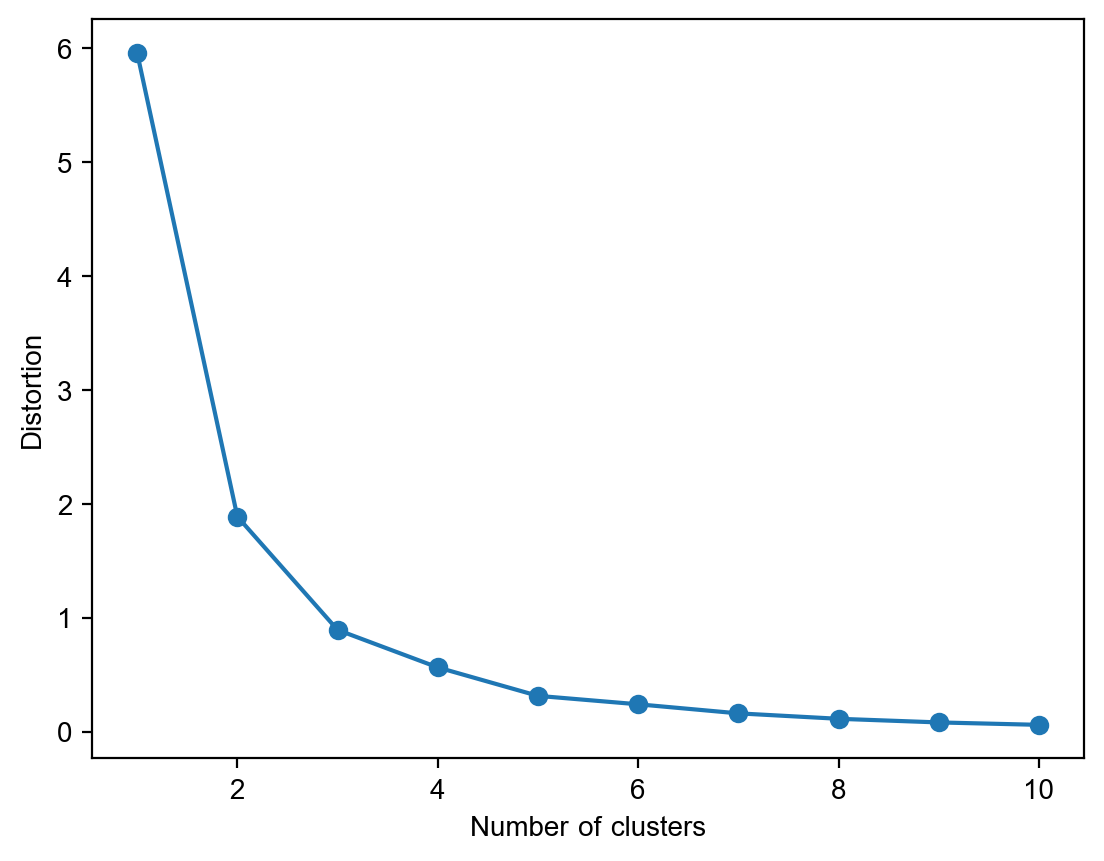

In [80]:
plot_distortion(np.array(df_scaled),max_clusters=10)

From the plot above, we could use 3 clusters

In [102]:
# Instantiate KMeans
km = KMeans(n_clusters=3, # clusters we expected 
            n_init=15, # initial runs
            random_state=0)

In [108]:
# Fit our data to the model
y_km = km.fit_predict(df_scaled)

In [112]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,0]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

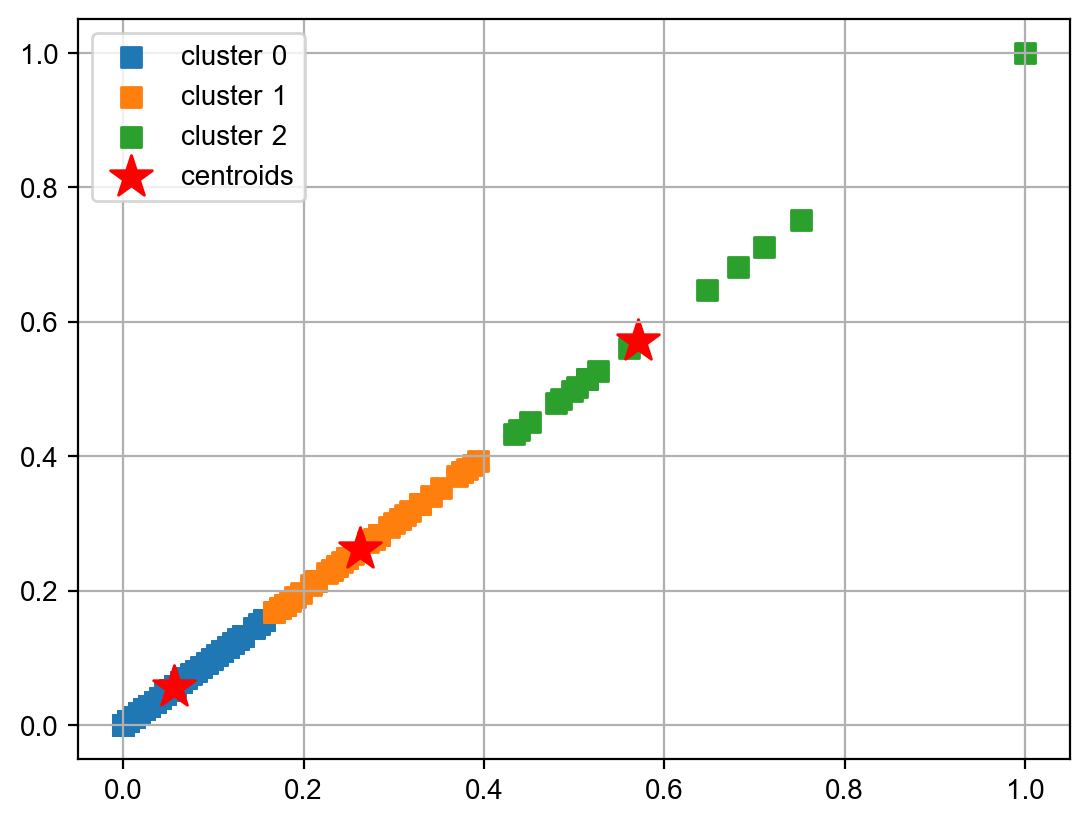

In [113]:
plot_clusters(df_scaled.to_numpy(), y_km, plt_cluster_centers= True)

We can see that it works, but we should add more features to get more significant clustering.

In [ ]:
# Let's try adding more features to our dataset for KMeans clustering

In [151]:
# Test code to get top entries from value_counts()
test = list(df['Neighborhood'].value_counts()[:3].index)
test.append(0)
test

['Chinatown', 'East Village', 'Lenox Hill', 0]

In [119]:
# Get a list with all unique neighborhoods
# We will use this as a filter in a for loop
hood_list = df['Neighborhood'].unique()

In [170]:
my_dict = {}

# This loop will iterate over each neighborhood and add
# the top category types for each
for hood in hood_list:
    #print(hood)
    df_filter = df[df['Neighborhood'] == hood]
    #print(df_filter['Category'].value_counts())
        
    if len(list(df_filter['Category'].value_counts()[:3].index)) == 3:
        my_dict[hood] = list(df_filter['Category'].value_counts()[:3].index)
    
    elif len(list(df_filter['Category'].value_counts()[:3].index)) == 2:
        to_list = list(df_filter['Category'].value_counts()[:3].index)
        #print(to_list)
        to_list.append('0')
        my_dict[hood] = to_list
        
    else: 
        to_list = list(df_filter['Category'].value_counts()[:3].index)
        #print(to_list)
        to_list.append('0')
        to_list.append('0')
        my_dict[hood] = to_list

In [171]:
# Check if for loop works properly
my_dict

{'Wakefield': ['Optometrist', '0', '0'],
 'Co-op City': ['Dentist', 'Health and Medicine', 'Physical Therapy Clinic'],
 'Fieldston': ['Dentist', 'Health and Medicine', 'Nutritionist'],
 'Riverdale': ['Health and Medicine', 'Dentist', "Doctor's Office"],
 'Kingsbridge': ['Health and Medicine', 'Dentist', 'Physical Therapy Clinic'],
 'Inwood': ['Dentist', 'Health and Medicine', 'Hospital'],
 'Marble Hill': ['Dentist',
  'Physical Therapy Clinic',
  'Assisted Living Service'],
 'Kingsbridge Heights': ['Home Health Care Service',
  'Hospital',
  'Health and Medicine'],
 'Woodlawn': ['Medical Lab', 'Emergency Room', "Doctor's Office"],
 'Norwood': ['Health and Medicine', 'Dentist', "Doctor's Office"],
 'Williamsbridge': ['Dentist', '0', '0'],
 'Baychester': ['Healthcare Clinic', 'Assisted Living Service', '0'],
 'Pelham Parkway': ['Dentist', "Doctor's Office", 'Ophthalmologist'],
 'Allerton': ['Chiropractor', 'Dentist', 'Nutritionist'],
 'City Island': ["Doctor's Office", 'Physical Therapy 

In [177]:
# Build our beautiful df 
top_venues = pd.DataFrame(data=my_dict).T
top_venues.columns = ['1st', '2nd', '3rd']
top_venues

,1st,2nd,3rd
Wakefield,Optometrist,0,0
Co-op City,Dentist,Health and Medicine,Physical Therapy Clinic
Fieldston,Dentist,Health and Medicine,Nutritionist
Riverdale,Health and Medicine,Dentist,Doctor's Office
Kingsbridge,Health and Medicine,Dentist,Physical Therapy Clinic
...,...,...,...
Manor Heights,Assisted Living Service,Health and Medicine,0
Egbertville,Nursing Home,Nutritionist,Hospice
Prince's Bay,Dentist,Internal Medicine Doctor,Doctor's Office
Hammels,Dentist,Physical Therapy Clinic,Healthcare Clinic


In [ ]:
# Now, we need to label each category with a number 
# We could either assign ordinal values, or get dummies

In [178]:
# How many unique categories are there? 
df.Category.nunique()

57

# Visualizations

In [51]:
# Import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import set_matplotlib_formats
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', quality=100)
import matplotlib
plt.rcParams["font.family"] = "garuda"

In [52]:
# Count number of venues 
cat_count = df['Category'].value_counts()

In [53]:
cat_count.sum()

5864

Preliminary plot of most common venues

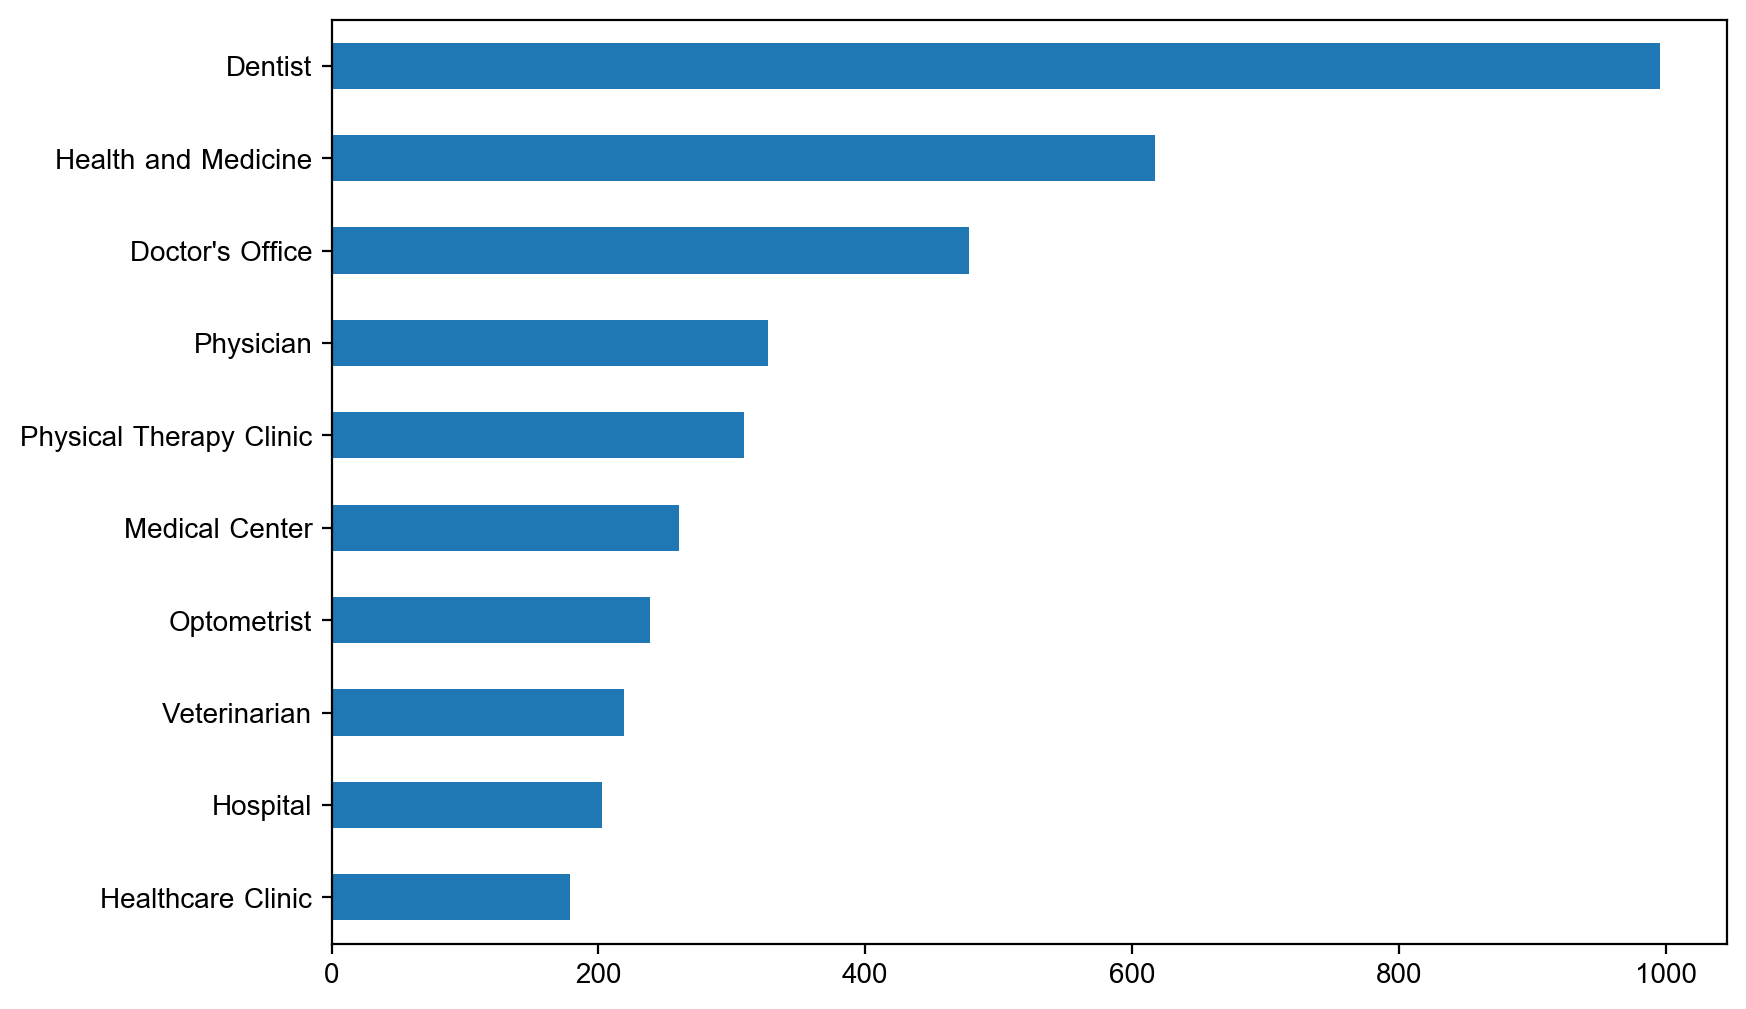

In [54]:
# Initialize fig and axes objects 
f, ax = plt.subplots(figsize=(9,6))

# Plot total number of venues
ax = cat_count.head(10).plot(kind='barh');
ax.invert_yaxis()

# Make the chart fill out the figure better.
#f.tight_layout()
plt.show()

Formatted plot of most common venues

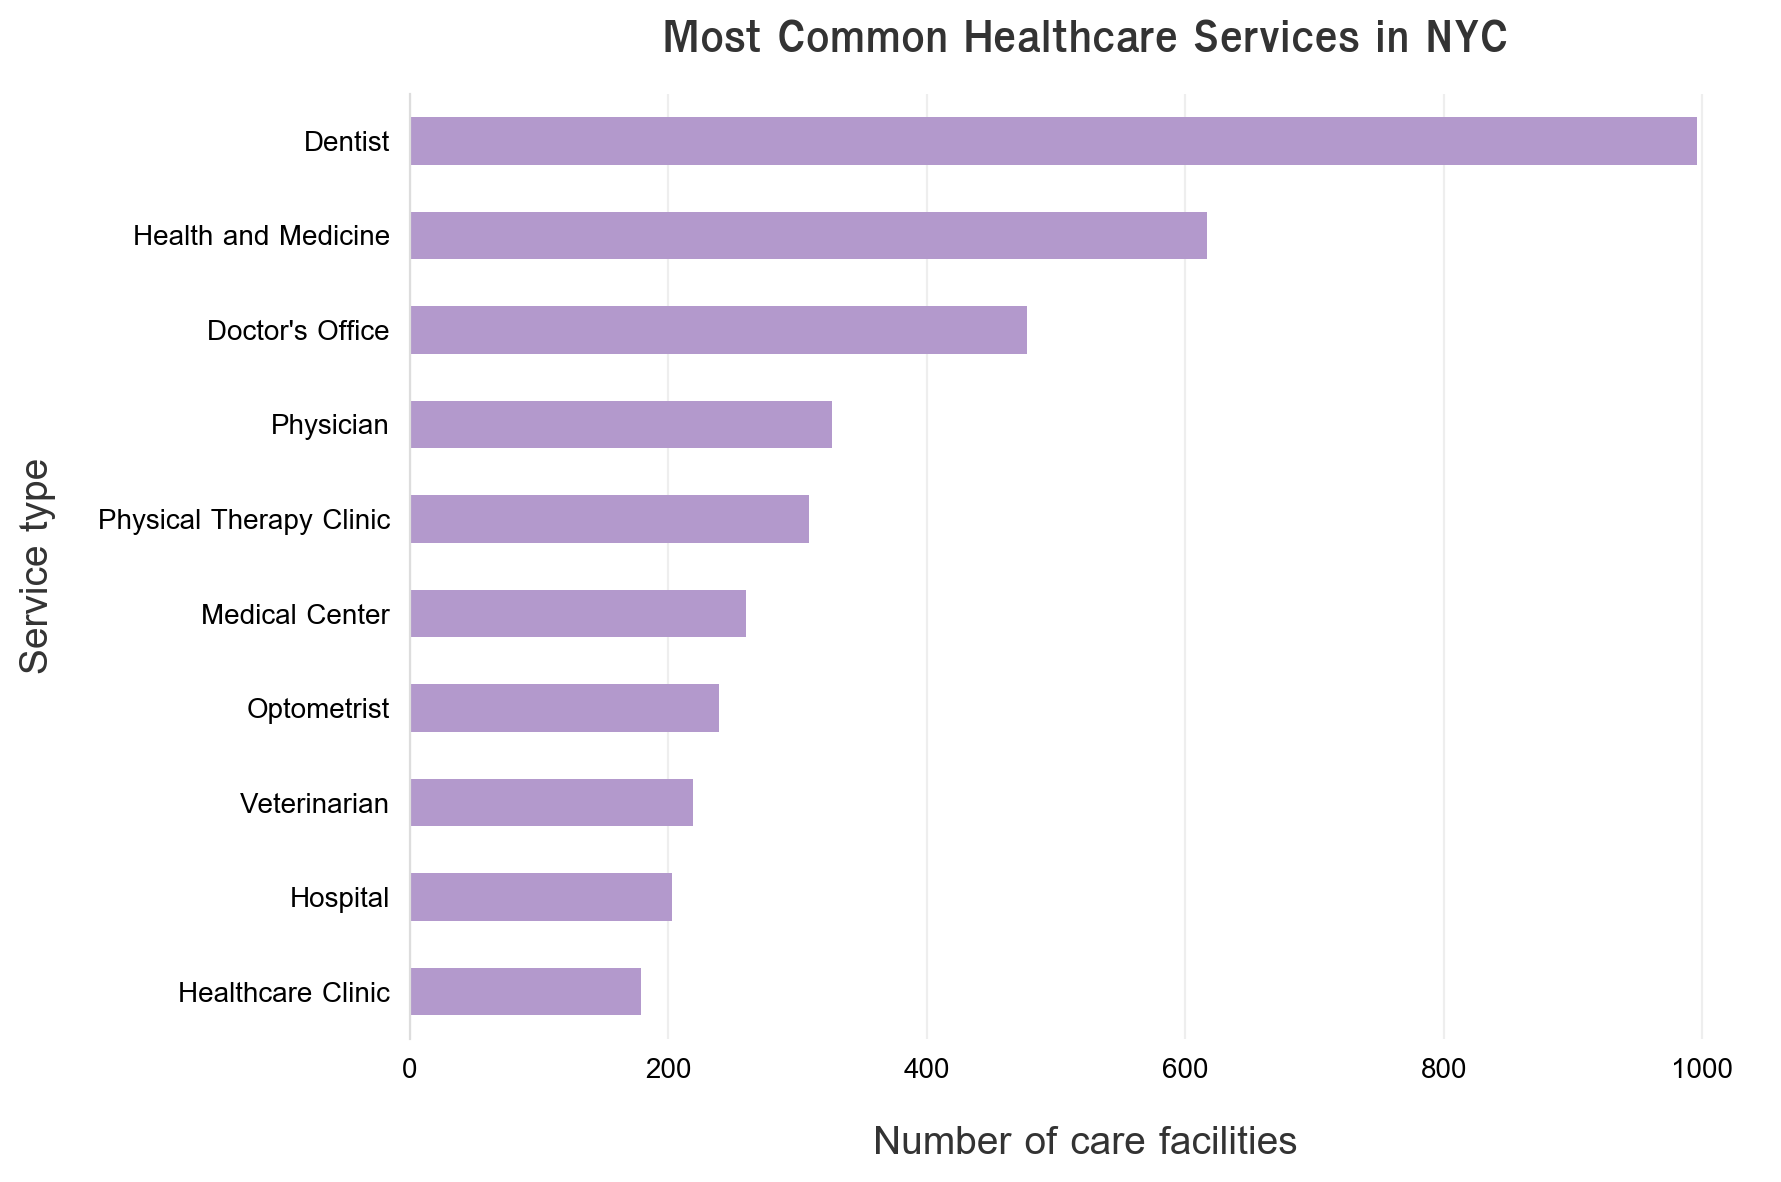

In [56]:
# Initialize fig and axes objects 
f, ax = plt.subplots(figsize=(9,6))

# Plot total number of venues
ax = cat_count.head(10).plot(kind='barh', color=(0.7, 0.6, 0.8, 1));
ax.invert_yaxis()

# Remove top, right and left spines (borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#DDDDDD')
ax.spines['bottom'].set_visible(False)

# Remove axis ticks
ax.tick_params(bottom=False, left=False)

# Keep the horizontal grid hidden.
# Color the vertical lines as light gray.
ax.set_axisbelow(True)
ax.yaxis.grid(False)
ax.xaxis.grid(True, color='#EEEEEE')

# Add labels and a title. 
csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}
ax.set_xlabel('Number of care facilities', labelpad=15, color='#333333', fontname='garuda', fontsize=14)
ax.set_ylabel('Service type', labelpad=15, color='#333333', fontname='garuda', fontsize=14)
ax.set_title('Most Common Healthcare Services in NYC',loc='center', pad=15, color='#333333',
             weight='bold', fontname='garuda', fontsize=16)

# Make the chart fill out the figure better.
f.tight_layout()
f.savefig('most-common-ven-nyc.png', dpi=300)

Which neighborhoods have more access to healthcare facilities?

In [110]:
df.head()

,Venue,Category,Latitude_x,Longitude_x,Neighborhood,ZIP,Borough,Longitude_y,Latitude_y
0,Wakefield Eye Care,Optometrist,40.898682,-73.849352,Wakefield,10466,Bronx,-73.847201,40.894705
1,Advanced Dental Group,Dentist,40.875278,-73.828492,Co-op City,10475,Bronx,-73.829939,40.874294
2,Creating Smiles,Dentist,40.871558,-73.830285,Co-op City,10475,Bronx,-73.829939,40.874294
3,NYC Health & Hospitals,Medical Center,40.873701,-73.826771,Co-op City,10475,Bronx,-73.829939,40.874294
4,Montefiore Medical Group,Physician,40.877116,-73.828470,Co-op City,10475,Bronx,-73.829939,40.874294


In [179]:
# Write code to select neighborhoods have the most entries
# Then plot in a bar chart


In [27]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))